<a href="https://colab.research.google.com/github/ApoorvaGrover/Inorganic-neural-synthesis/blob/main/inorganics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing dataset and libraries

In [ ]:
# band_ml_bigdata.py
# CPU-only bandgap pipeline for ~100 samples (synthetic labels).
# Requirements: numpy, pandas, scikit-learn, matplotlib
import os, math, random, re
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.manifold import TSNE

os.makedirs('data', exist_ok=True)
os.makedirs('data/figs', exist_ok=True)
random.seed(42)
np.random.seed(42)

# === Helper: elemental properties (small subset) ===
# (atomic_number, pauling_electronegativity, atomic_radius_pm)
elem_props = {
 'H': (1, 2.20, 53), 'Li': (3, 0.98, 167), 'Be': (4, 1.57, 112),
 'B': (5, 2.04, 87), 'C': (6, 2.55, 67), 'N': (7, 3.04, 56),
 'O': (8, 3.44, 48), 'F': (9, 3.98, 42), 'Na': (11, 0.93, 190),
 'Mg': (12, 1.31, 145), 'Al': (13, 1.61, 118), 'Si': (14, 1.90, 111),
 'P': (15, 2.19, 98), 'S': (16, 2.58, 88), 'Cl': (17, 3.16, 79), 'K':(19,0.82,243),
 'Ca': (20, 1.00, 194), 'Sc':(21,1.36,184),'Ti': (22, 1.54, 176), 'V': (23, 1.63, 171),
 'Cr': (24,1.66,166),'Mn':(25,1.55,161),'Fe':(26,1.83,156),'Co':(27,1.88,152),
 'Ni':(28,1.91,149),'Cu':(29,1.90,145),'Zn':(30,1.65,142),'Ga':(31,1.81,135),
 'Ge':(32,2.01,122),'As':(33,2.18,119),'Se':(34,2.55,116),'Br':(35,2.96,114),
 'Kr':(36,3.00,110),'Rb':(37,0.82,265),'Sr':(38,0.95,215),'Y':(39,1.22,212),
 'Zr':(40,1.33,206),'Nb':(41,1.6,198),'Mo':(42,2.16,190),'Ag':(47,1.93,144),
 'Cd':(48,1.69,151),'In':(49,1.78,167),'Sn':(50,1.96,140),'Sb':(51,2.05,139),
 'Te':(52,2.1,135),'I':(53,2.66,133),'Ba':(56,0.89,253),'Pt':(78,2.28,139),
 'Au':(79,2.54,144),'Hg':(80,2.00,151),'Pb':(82,2.33,175),'Li':(3,0.98,167)
}


training and validating the dataset

In [ ]:
# === Simple formula parser (no parentheses) ===
def parse_formula(formula):
    tokens = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    comp = Counter()
    for el, cnt in tokens:
        cnt = int(cnt) if cnt!='' else 1
        comp[el] += cnt
    return dict(comp)

# === Featurizer: composition-derived simple descriptors ===
def featurize_formula(formula):
    comp = parse_formula(formula)
    total_atoms = sum(comp.values())
    if total_atoms == 0:
        return None
    zn_mean = en_mean = ar_mean = 0.0
    max_en = -1e9; min_en = 1e9
    frac_O = comp.get('O', 0)/total_atoms
    frac_F = comp.get('F', 0)/total_atoms
    unique_elems = len(comp)
    for el, cnt in comp.items():
        props = elem_props.get(el, (0, 1.5, 150))
        z, en, ar = props
        weight = cnt/total_atoms
        zn_mean += weight*z
        en_mean += weight*en
        ar_mean += weight*ar
        max_en = max(max_en, en)
        min_en = min(min_en, en)
    en_diff = max_en - min_en if unique_elems>1 else 0.0
    return {
        'zn_mean': zn_mean,
        'en_mean': en_mean,
        'en_diff': en_diff,
        'ar_mean': ar_mean,
        'frac_O': frac_O,
        'frac_F': frac_F,
        'unique_elems': unique_elems,
        'total_atoms': total_atoms
    }


In [ ]:
# === Build ~100 compound formulas ===
# Start with a curated seed of common inorganic compounds
seed = [
 'Si','Ge','GaAs','ZnO','TiO2','Al2O3','MgO','SnO2','CdS','CaO','BN','LiF',
 'Cu2O','Fe2O3','Fe3O4','NiO','CoO','PbS','PbSe','InP','InAs','GaN','AlN',
 'MoS2','WS2','ZnS','ZnSe','AgCl','AgBr','NaCl','KCl','CsI','SrTiO3','BaTiO3',
 'La2O3','CeO2','ZrO2','HfO2','Nb2O5','Ta2O5','V2O5','SnS2','Bi2O3','Sb2S3'
]

# Now programmatically create more compounds by substitutions & simple stoichiometry
extra = []
# Common anions and metals to combine
metals = ['Al','Si','Ge','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','In','Sn','Pb','Ca','Mg','Sr','Ba']
anions = ['O','S','Se','N','F','Cl','Br']
for m in metals:
    for a in anions:
        # create oxide/sulfide/nitride etc with simple formula m + a + '2' in some proportion
        f = m + a + '2'  # e.g., TiO2, FeS2
        extra.append(f)
        if len(extra) >= 60: break
    if len(extra) >= 60: break

# Also add some binary salts and halides
halide_pairs = [('Na','Cl'),('K','Cl'),('Li','F'),('Cs','I'),('Ag','Cl'),('Ag','Br')]
for c,a in halide_pairs:
    extra.append(c + a)

# Merge seeds and extras, dedupe and limit to ~100
all_compounds = list(dict.fromkeys(seed + extra))
# If fewer than 100, create slight composition variants
i = 0
while len(all_compounds) < 100:
    base = random.choice(all_compounds[:80])
    # randomly add small stoichiometry or substitute element
    comp = parse_formula(base)
    # randomly add O or F
    if 'O' in elem_props and random.random() < 0.3:
        new = base + 'O'
    else:
        new = base + '2'
    if new not in all_compounds:
        all_compounds.append(new)
    i += 1
    if i > 500: break

# Trim to 100
all_compounds = all_compounds[:100]

# === Synthetic bandgap generator (physics-inspired heuristic) ===
def synthetic_bandgap(formula):
    # heuristic: larger EN difference and presence of highly electronegative anions -> larger gaps
    feats = featurize_formula(formula)
    if feats is None:
        return 1.0 + np.random.randn()*0.2
    en = feats['en_mean']
    en_diff = feats['en_diff']
    frac_O = feats['frac_O']
    frac_F = feats['frac_F']
    unique = feats['unique_elems']
    ar = feats['ar_mean']
    # base: metals/low en mean -> small Eg, ionic (O/F) -> larger Eg
    base = max(0.05, 3.0 * (en_diff) + 0.5 * (frac_O + 1.2*frac_F) - 0.02*(ar/100))
    # add term for covalent semiconductors (moderate en_mean)
    cov_term = 0.0
    if 1.5 < en < 2.5:
        cov_term = 1.0
    # scale and add noise
    eg = base + cov_term + np.random.normal(0, 0.3)
    # clip to plausible range [0, 15]
    return float(max(0.0, min(15.0, eg)))


build dataset with synthetic labels

deep learning neural synthesis training testing and splitting the data

Created dataset with 100 samples. Saved to data/data_big_inorganics_features_synthetic.csv
  formula  band_gap_eV    zn_mean   en_mean  en_diff     ar_mean    frac_O  \
0      Si        1.199  14.000000  1.900000     0.00  111.000000  0.000000   
1      Ge        1.009  32.000000  2.010000     0.00  122.000000  0.000000   
2    GaAs        2.279  32.000000  1.995000     0.37  127.000000  0.000000   
3     ZnO        6.058  19.000000  2.545000     1.79   95.000000  0.500000   
4    TiO2        5.945  12.666667  2.806667     1.90   90.666667  0.666667   
5   Al2O3        5.705  10.000000  2.708000     1.83   76.000000  0.600000   
6     MgO        8.094  10.000000  2.375000     2.13   96.500000  0.500000   
7    SnO2        4.988  22.000000  2.946667     1.48   78.666667  0.666667   
8     CdS        3.505  32.000000  2.135000     0.89  119.500000  0.000000   
9     CaO        8.709  14.000000  2.220000     2.44  121.000000  0.500000   

   frac_F  unique_elems  total_atoms  
0     0.0  

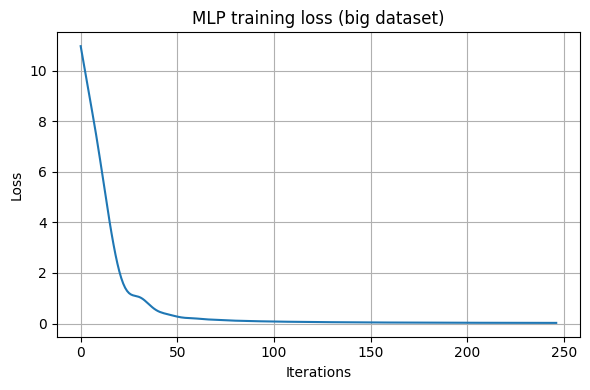

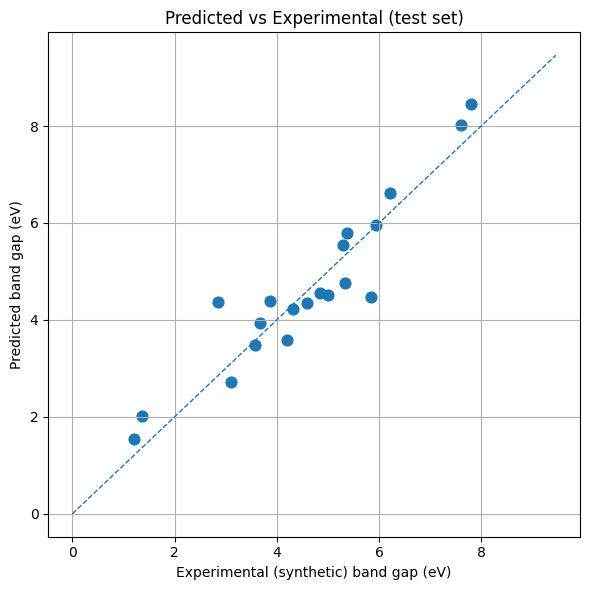

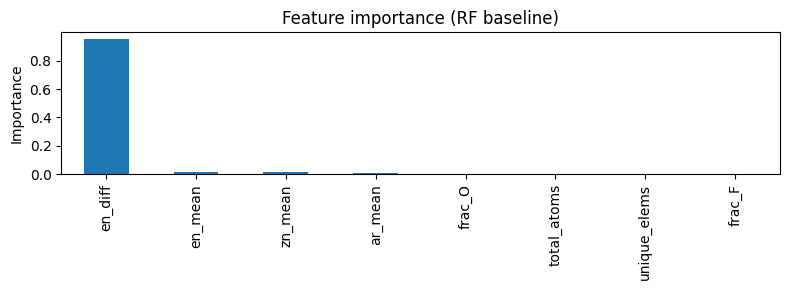

Feature importances:
 en_diff         0.951933
en_mean         0.016632
zn_mean         0.015790
ar_mean         0.007958
frac_O          0.003407
total_atoms     0.002647
unique_elems    0.001401
frac_F          0.000232
dtype: float64


In [ ]:
# === Build dataset with synthetic labels ===
rows = []
for f in all_compounds:
    feats = featurize_formula(f)
    if feats is None:
        continue
    eg = synthetic_bandgap(f)
    rows.append({'formula': f, 'band_gap_eV': round(eg, 3), **feats})

df_feat = pd.DataFrame(rows)
df_feat.to_csv('data/data_big_inorganics_features_synthetic.csv', index=False)
print(f"Created dataset with {len(df_feat)} samples. Saved to data/data_big_inorganics_features_synthetic.csv")
print(df_feat.head(10))

# === Prepare ML data ===
feature_cols = ['zn_mean','en_mean','en_diff','ar_mean','frac_O','frac_F','unique_elems','total_atoms']
X = df_feat[feature_cols].values.astype(float)
y = df_feat['band_gap_eV'].values.astype(float)

# Train-test split (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

mean = X_train.mean(axis=0); std = X_train.std(axis=0)
X_train_s = (X_train - mean) / (std + 1e-9); X_test_s = (X_test - mean) / (std + 1e-9)

# === Train MLP (CPU) ===
mlp = MLPRegressor(hidden_layer_sizes=(128,64,32), activation='relu', max_iter=3000, random_state=42)
print("Training MLP on", X_train_s.shape[0], "samples...")
mlp.fit(X_train_s, y_train)

# Predictions & metrics
y_pred_test = mlp.predict(X_test_s)
y_pred_test = np.maximum(0.0, y_pred_test)  # enforce Eg >= 0
mae = mean_absolute_error(y_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f'Test MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}')

# === Plots ===
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.title('MLP training loss (big dataset)')
plt.grid(True); plt.tight_layout(); plt.savefig('data/figs/training_loss_big.png', dpi=200); plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, s=60)
mx = max(max(y_test), max(y_pred_test)) + 1.0
plt.plot([0,mx],[0,mx], '--', linewidth=1)
plt.xlabel('Experimental (synthetic) band gap (eV)'); plt.ylabel('Predicted band gap (eV)')
plt.title('Predicted vs Experimental (test set)')
plt.grid(True); plt.tight_layout(); plt.savefig('data/figs/pred_vs_exp_big.png', dpi=200); plt.show()

# === Random Forest baseline and feature importance ===
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_s, y_train)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,3))
feat_imp.plot(kind='bar')
plt.ylabel('Importance'); plt.title('Feature importance (RF baseline)')
plt.tight_layout(); plt.savefig('data/figs/feature_importance_big.png', dpi=200); plt.show()
print('Feature importances:\n', feat_imp)

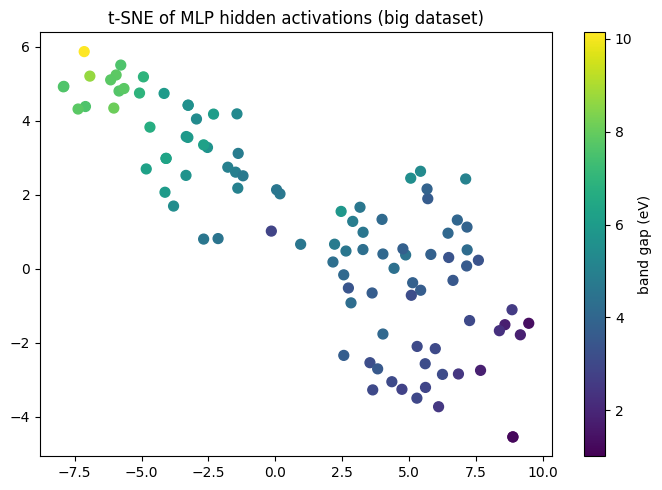

Saved results to:
 - data/data_big_inorganics_features_synthetic.csv
 - data/bandgap_predictions_table_big_synthetic.csv
 - figures in data/figs/
Dataset size: 100
  formula  true_bandgap  pred_bandgap
0      Si         1.199      6.830560
1      Ge         1.009      4.382947
2    GaAs         2.279      3.458505
3     ZnO         6.058      6.218554
4    TiO2         5.945      4.654509
5   Al2O3         5.705      4.658211
6     MgO         8.094      5.853783
7    SnO2         4.988      6.942058
8     CdS         3.505      8.830487
9     CaO         8.709      3.706513


In [ ]:
# === t-SNE on MLP hidden outputs (approx) ===
def mlp_hidden_outputs(mlp, X):
    Xh = X.copy()
    # use pretrained weights to compute activations (ReLU)
    for i in range(len(mlp.coefs_) - 1):
        Xh = Xh.dot(mlp.coefs_[i]) + mlp.intercepts_[i]
        Xh = np.maximum(0, Xh)
    return Xh

X_all = np.vstack([X_train_s, X_test_s])
hidden_emb = mlp_hidden_outputs(mlp, X_all)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
emb2 = tsne.fit_transform(hidden_emb)
y_all = np.concatenate([y_train, y_test])
plt.figure(figsize=(7,5))
sc = plt.scatter(emb2[:,0], emb2[:,1], c=y_all, cmap='viridis', s=50)
plt.colorbar(sc, label='band gap (eV)')
plt.title('t-SNE of MLP hidden activations (big dataset)')
plt.tight_layout(); plt.savefig('data/figs/tsne_embeddings_big.png', dpi=200); plt.show()

# === Save predictions and dataset ===
results_df = pd.DataFrame({
    'formula': df_feat['formula'],
    'true_bandgap': df_feat['band_gap_eV'],
    'pred_bandgap': np.concatenate([mlp.predict(X_train_s), mlp.predict(X_test_s)])[:len(df_feat)]
})
results_df['pred_bandgap'] = results_df['pred_bandgap'].clip(lower=0.0)
results_df.to_csv('data/bandgap_predictions_table_big_synthetic.csv', index=False)
df_feat.to_csv('data/data_big_inorganics_features_synthetic.csv', index=False)

print("Saved results to:")
print(" - data/data_big_inorganics_features_synthetic.csv")
print(" - data/bandgap_predictions_table_big_synthetic.csv")
print(" - figures in data/figs/")
print("Dataset size:", len(df_feat))
print(results_df.head(10))

In [ ]:
!pip install pandas numpy scikit-learn torch matplotlib

project/
│
├── data/
│   └── inorganics.csv      # Your dataset (features + target)
├── model/
│   └── baseline_nn.py      # NN model definition
└── train.py                # Training script


In [ ]:
import torch
import torch.nn as nn

class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super(BaselineNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import pandas as pd
import os

# Create small experimental dataset
data = {
    "formula": [
        "Si", "Ge", "GaAs", "ZnO", "TiO2 (anatase)",
        "Al2O3", "MgO", "SrTiO3", "PbS", "CdS"
    ],
    "band_gap (eV)": [
        1.12, 0.66, 1.43, 3.37, 3.20,
        8.8, 7.8, 3.25, 0.41, 2.42
    ]
}

df = pd.DataFrame(data)

# Create directory and save
os.makedirs("data", exist_ok=True)
df.to_csv("data/small_inorganics.csv", index=False)

print("✅ Saved: data/small_inorganics.csv")


✅ Saved: data/small_inorganics.csv


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re

# Load data
df = pd.read_csv('data/small_inorganics.csv')

# Element atomic numbers for quick lookup
atomic_numbers = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26,
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34,
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42,
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58,
    'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66,
    'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74,
    'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86
}

# Function to parse formula and compute average atomic number
def avg_atomic_number(formula):
    # Find all elements with optional counts, e.g. Fe2, O3
    tokens = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    total = 0
    count = 0
    for elem, num in tokens:
        num = int(num) if num else 1
        if elem in atomic_numbers:
            total += atomic_numbers[elem] * num
            count += num
        else:
            # Unknown element - skip or handle as zero
            pass
    return total / count if count > 0 else 0

# Compute feature
df['avg_atomic_num'] = df['formula'].apply(avg_atomic_number)

# Features and target
X = df[['avg_atomic_num']].values
y = df['band_gap (eV)'].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Simple NN Model
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model, loss, optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 40 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test).item()

print(f"\nTest MSE Loss: {test_loss:.4f}")

# Example prediction (inverse scale)
predicted_bandgap = scaler_y.inverse_transform(test_preds.numpy())
print(f"Predicted bandgap (test samples): {predicted_bandgap.flatten()}")


Epoch 1/200, Loss: 1.2546
Epoch 40/200, Loss: 0.1716
Epoch 80/200, Loss: 0.0843
Epoch 120/200, Loss: 0.0759
Epoch 160/200, Loss: 0.0587
Epoch 200/200, Loss: 0.0264

Test MSE Loss: 0.1967
Predicted bandgap (test samples): [-0.64393514  1.9498467 ]


In [ ]:
import os, math, random, re
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.manifold import TSNE

os.makedirs('data', exist_ok=True)
os.makedirs('data/figs', exist_ok=True)
random.seed(42)
np.random.seed(42)
